# 使用seq2seq模型对序列数据滑动窗口进行训练

In [4]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd

In [7]:
# 模拟数据获取
from airplane import Airplane
from receiver import Receiver

airplane1 = Airplane('782034',[120.128234,30.2141348,10000],[115.86143245,28.750012,10000],180,3340)
receiver1 = Receiver([114.122588,36.548925,1000])
time_track1 =receiver1.fin_time_track(airplane1)
track1 = airplane1.track

5017 5017


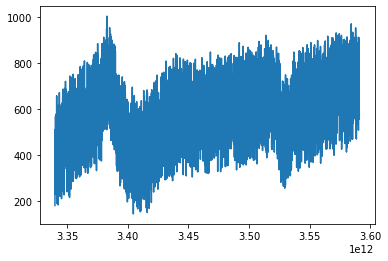

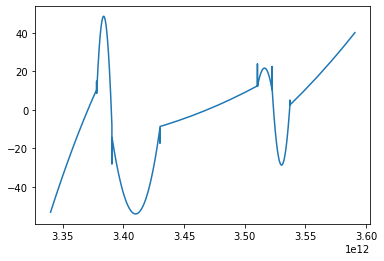

In [8]:
# 预处理step1
# 获取前后数据包时间差
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt,pi, atan

using_data = time_track1
time_error = []
location_error = []
print(len(track1),len(using_data))

for i in range(len(using_data)-1):
    time_error.append(using_data[i+1]-using_data[i]-50000000)#-(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))*10/3)
    location_error.append(airplane1.geodistance(track1[i+1],receiver1.location)-airplane1.geodistance(track1[i],receiver1.location))
    
# plt.plot(using_data[19:79], test_data[19:79])
plt.plot(using_data[:-1], time_error)
plt.show()
# plt.ylim(0.39,0.6)
# plt.xlim(0.39,0.6)
plt.plot(using_data[:-1], location_error)
plt.show()


In [ ]:


# 模拟数据
t = np.linspace(1, 100, 100)
a = 0.5
position = (a * t * 2) / 2

position_noise = position + np.random.normal(0, 1200, size=(t.shape[0]))


plt.plot(t, position, label='truth position')
plt.plot(t, position_noise, label='only use measured position')

# 初试的估计导弹的位置就直接用GPS测量的位置
predicts = [position_noise[0]]
position_predict = predicts[0]

predict_var = 0
odo_var = 200 ** 2  # 这是我们自己设定的位置测量仪器的方差，越大则测量值占比越低
v_std = 50  # 测量仪器的方差
for i in range(1, t.shape[0]):
    dv = (position[i] - position[i - 1]) + np.random.normal(0, 50)  # 模拟从IMU读取出的速度
    position_predict = position_predict + dv  # 利用上个时刻的位置和速度预测当前位置
    predict_var += v_std ** 2  # 更新预测数据的方差
    # 下面是Kalman滤波
    position_predict = position_predict * odo_var / (predict_var + odo_var) + position_noise[i] * predict_var / (
                predict_var + odo_var)
    predict_var = (predict_var * odo_var) / (predict_var + odo_var) ** 2
    predicts.append(position_predict)

plt.plot(t, predicts, label='kalman filtered position')

plt.legend()
plt.show()


In [ ]:
# 预处理step2
# 划分训练集和测试集

x_data = torch.tensor(time_error)
y_data = torch.tensor(location_error)
print(x_data)
print(y_data)

test_size = 1000

x_train_set = time_error[: -test_size]
x_test_set = time_error[-test_size:]

y_train_set = location_error[: -test_size]
y_test_set = location_error[-test_size:]

In [4]:
# 预处理step3
# 训练集数据归一化，并化为cuda类型
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range=(-1,1))

x_train_set_array = np.array(x_train_set)
x_train_norm = sc.fit_transform(x_train_set_array.reshape(-1,1))
x_train_norm = torch.FloatTensor(x_train_norm).view(-1).cuda()

y_train_set_array = np.array(y_train_set)
y_train_norm = sc.fit_transform(y_train_set_array.reshape(-1,1))
y_train_norm = torch.FloatTensor(y_train_norm).view(-1).cuda()

# train_set_array = np.array(train_set)
# train_norm = sc.fit_transform(train_set_array.reshape(-1,1))
# train_norm = torch.FloatTensor(train_norm).view(-1).cuda()


In [5]:
print(x_train_norm)

tensor([ 0.3341,  0.2660, -0.0952,  ...,  0.1298,  0.3293,  0.1714],
       device='cuda:0')


In [6]:
# 预处理step4
# 将数据处理为lstm接受的类型
lenth = len(x_train_norm)
train_data = []
for i in range(lenth):
    train_data.append((x_train_norm[i:i+1],y_train_norm[i:i+1]))

print(train_data[0:10])

[(tensor([0.3341], device='cuda:0'), tensor([0.2961], device='cuda:0')), (tensor([0.2660], device='cuda:0'), tensor([0.2867], device='cuda:0')), (tensor([-0.0952], device='cuda:0'), tensor([0.2773], device='cuda:0')), (tensor([0.2885], device='cuda:0'), tensor([0.2679], device='cuda:0')), (tensor([-0.0662], device='cuda:0'), tensor([0.2586], device='cuda:0')), (tensor([0.0985], device='cuda:0'), tensor([0.2493], device='cuda:0')), (tensor([0.2657], device='cuda:0'), tensor([0.2400], device='cuda:0')), (tensor([0.1740], device='cuda:0'), tensor([0.2308], device='cuda:0')), (tensor([0.2940], device='cuda:0'), tensor([0.2216], device='cuda:0')), (tensor([0.5287], device='cuda:0'), tensor([0.2124], device='cuda:0'))]


In [7]:
print(train_data[0][1])

tensor([0.2961], device='cuda:0')


# seq2seq模型
首先将输入的序列数据压缩为指定长度的向量（encoder）

然后将指定长度的向量解码成不定长度的序列数据（decoder）

然后将序列数据一一对应（seq2seq）

In [3]:
class Encoder(nn.Module):
    
    def __init__(self, input_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        
    def forward(self, seq):
        outputs, (hn, cn) = self.lstm(seq)
        return outputs, hn, cn

In [ ]:
class Decoder(nn.Module):

    def __init__(self, input_size, hidden_size, n_layers, dropout, recurrent_dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(input_size, hidden_size,
                            num_layers=n_layers,
                            dropout=(recurrent_dropout if n_layers > 1 else 0))
        self.fc = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, input_index, h_state, c_state):
#         embedded = self.embedding(input_word_index.unsqueeze(0))
#         embedded = self.dropout(embedded)
        outputs, (h_state, c_state) = self.lstm(embedded, (h_state, c_state))
        # outputs: [1, batch_size, hidden_size]
        logit = self.fc(outputs.squeeze(0))
        return logit, h_state, c_state

In [8]:
# lstm模型
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50,out_size=1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.linear = nn.Linear(hidden_size,out_size)
        self.hidden = ( torch.zeros(1, 1, hidden_size), torch.zeros(1, 1, hidden_size))

    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq), 1, -1), self.hidden)
        pred= self.linear(lstm_out.view(len(seq), -1))

        return pred[-1]


torch.manual_seed(42)
model = LSTM().cuda()
# train_data.cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01)


print(model)


for p in model.parameters():
    print(p.numel())

LSTM(
  (lstm): LSTM(1, 50)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)
200
10000
200
200
50
1


In [ ]:
class SeqToSeqNet(nn.Module):

    def __init__(self, encoder, decoder, device):
        assert encoder.n_layers == decoder.n_layers, 'Encoder and Decoder must have the same number of reccurent layers'
        assert encoder.hidden_size == decoder.hidden_size, 'Encoder and Decoder must have the same number of reccurrent hidden units'

        super(SeqToSeqNet, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, input_sequences, sequence_lengths, target_sequences, tf_ratio):
        """
        :params
            input_sequences: Tensor[seq_len, batch_size]
            sequence_lengths: Tensor[batch_size,]
            target_sequences: Tensor[seq_len, batch_size]
            tf_ratio: float
            
        :return
            outputs: Tensor[seq_len - 1, batch_size, vocab_size]
                Since we ignore the SOS_TOKEN
        """
        _, h_state, c_state = self.encoder(input_sequences, sequence_lengths)
        
        seq_len, batch_size = target_sequences.size()
        outputs = torch.zeros(seq_len - 1, batch_size, self.decoder.vocab_size).to(self.device)
        word_index = target_sequences[0, :]
        
        for t, idx in enumerate(range(1, seq_len)):
            output, h_state, c_state = self.decoder(word_index, h_state, c_state)
            # output: [batch_size, vocab_size]
            outputs[t] = output
            
            if random.random() < tf_ratio:
                word_index = target_sequences[idx, :]
            else:
                word_index = output.argmax(dim=1)
                
        return outputs

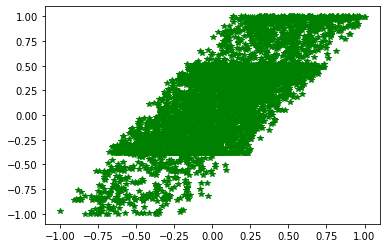

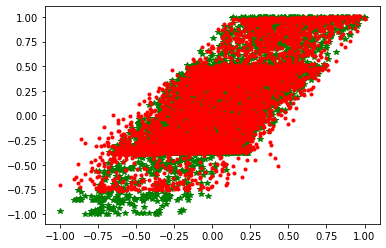

 Epoch 0 Loss:  0.0001536484487587586


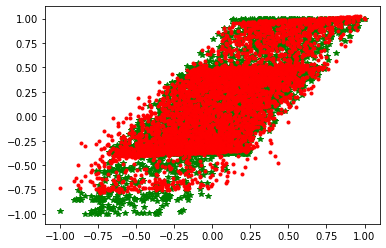

 Epoch 1 Loss:  0.0002231473190477118


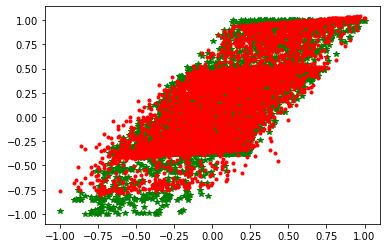

 Epoch 2 Loss:  0.0002945371379610151


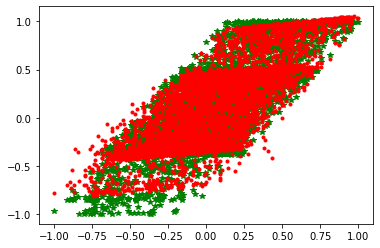

 Epoch 3 Loss:  0.00035916295018978417


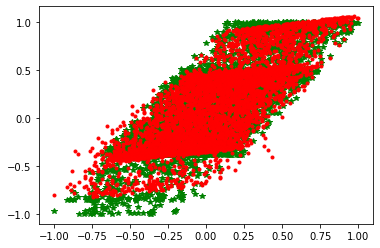

 Epoch 4 Loss:  0.00040955664007924497


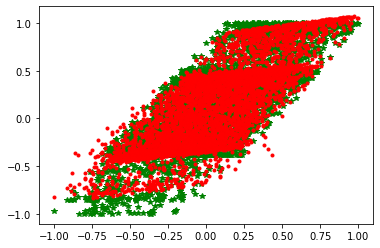

 Epoch 5 Loss:  0.00044389732647687197


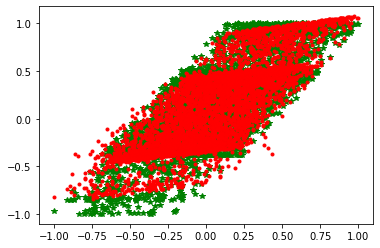

 Epoch 6 Loss:  0.0004647442256100476


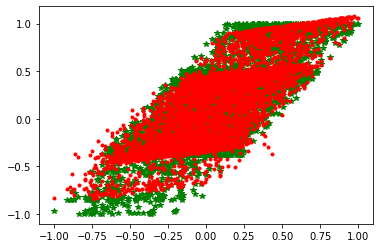

 Epoch 7 Loss:  0.000476007437100634


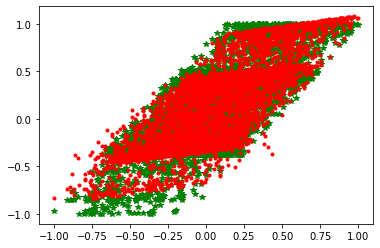

 Epoch 8 Loss:  0.00048106908798217773


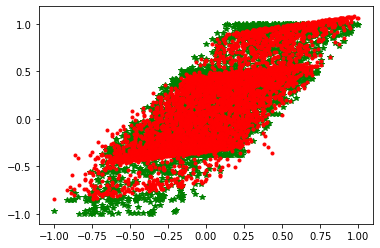

 Epoch 9 Loss:  0.0004822922346647829


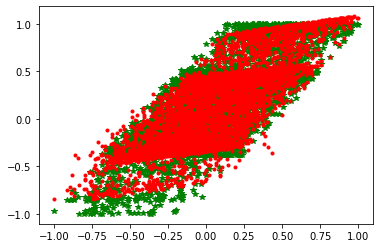

 Epoch 10 Loss:  0.00048117368714883924


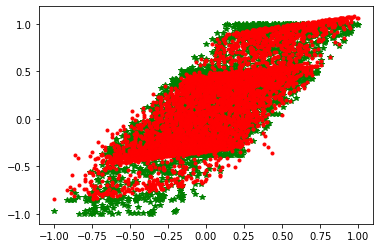

 Epoch 11 Loss:  0.0004785844648722559


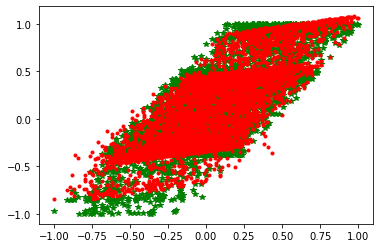

 Epoch 12 Loss:  0.0004750443040393293


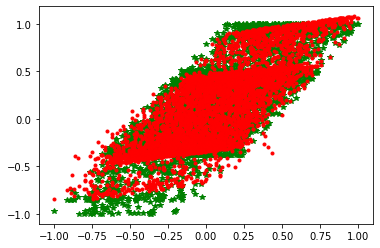

 Epoch 13 Loss:  0.000470831582788378


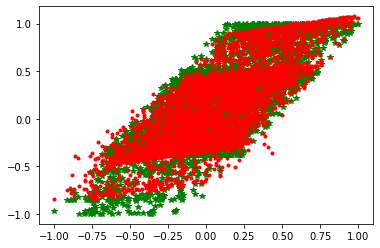

 Epoch 14 Loss:  0.00046610983554273844


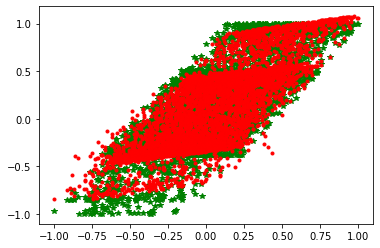

 Epoch 15 Loss:  0.0004609587776940316


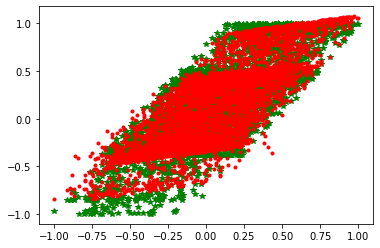

 Epoch 16 Loss:  0.0004554291954264045


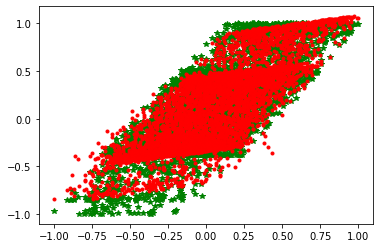

 Epoch 17 Loss:  0.00044955377234146


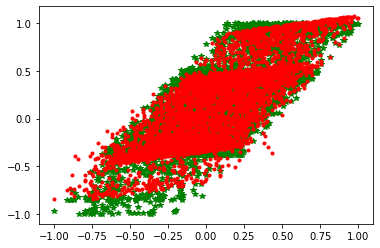

 Epoch 18 Loss:  0.0004433348949532956


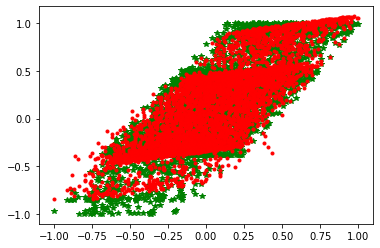

 Epoch 19 Loss:  0.00043678804649971426


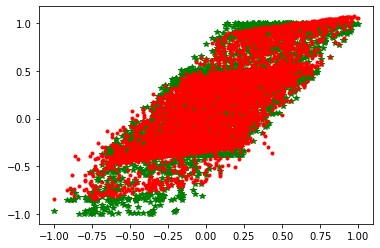

 Epoch 20 Loss:  0.00042991162627004087


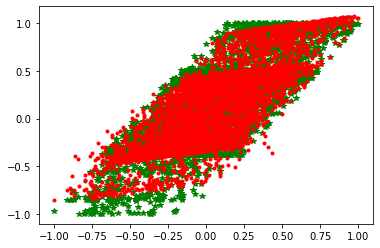

 Epoch 21 Loss:  0.00042271221172995865


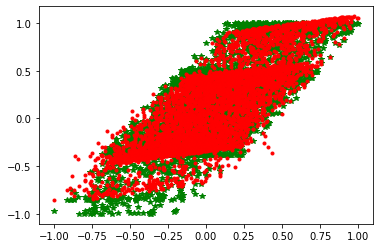

 Epoch 22 Loss:  0.00041519946535117924


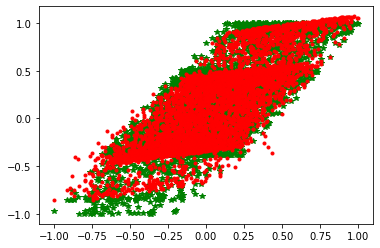

 Epoch 23 Loss:  0.0004073666059412062


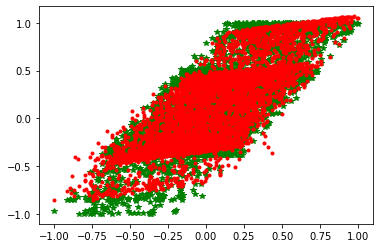

 Epoch 24 Loss:  0.0003992223646491766


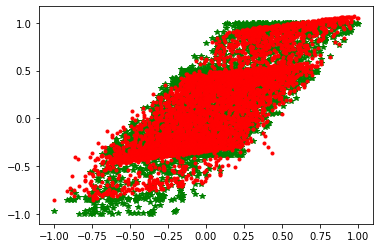

 Epoch 25 Loss:  0.0003907714562956244


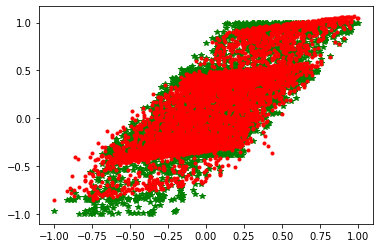

 Epoch 26 Loss:  0.0003820170823018998


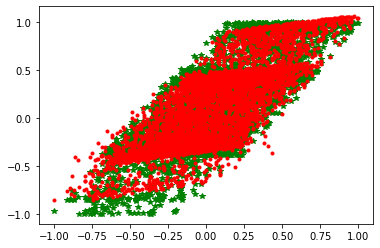

 Epoch 27 Loss:  0.0003729680902324617


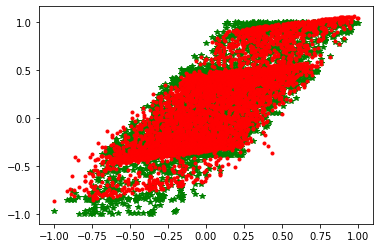

 Epoch 28 Loss:  0.0003636296314653009


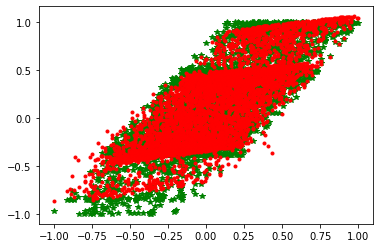

 Epoch 29 Loss:  0.00035401471541263163


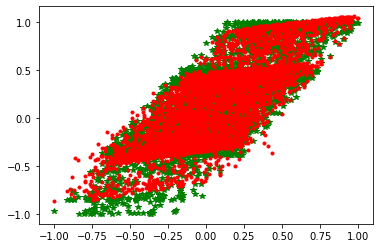

 Epoch 30 Loss:  0.0003441260487306863


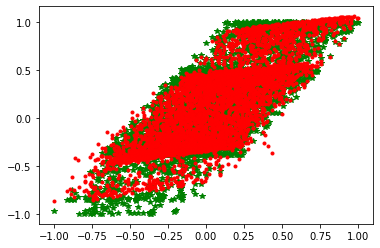

 Epoch 31 Loss:  0.0003339873510412872


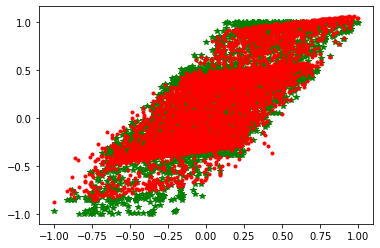

 Epoch 32 Loss:  0.00032360124168917537


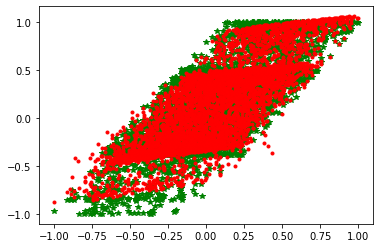

 Epoch 33 Loss:  0.0003129868127871305


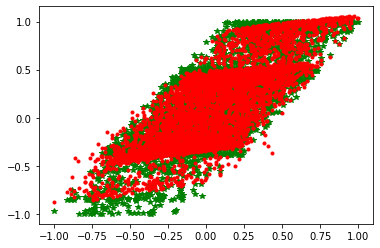

 Epoch 34 Loss:  0.00030216382583603263


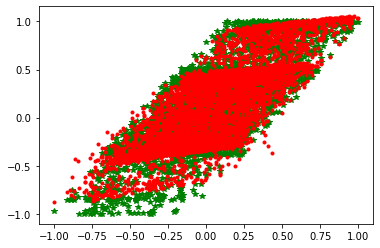

 Epoch 35 Loss:  0.00029115076176822186


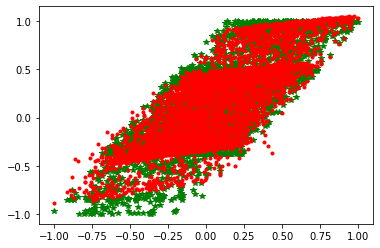

 Epoch 36 Loss:  0.00027996706194244325


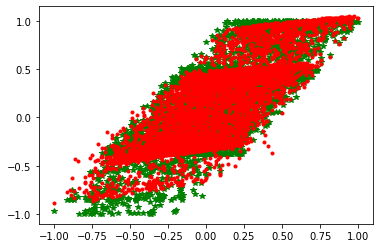

 Epoch 37 Loss:  0.00026864270330406725


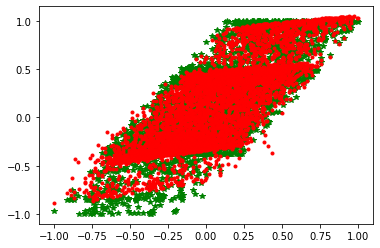

 Epoch 38 Loss:  0.0002572040830273181


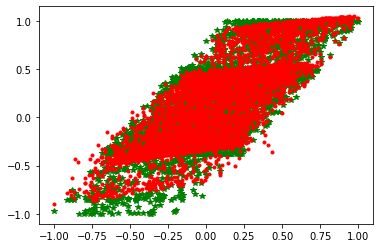

 Epoch 39 Loss:  0.0002456815855111927


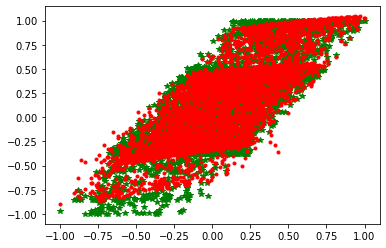

 Epoch 40 Loss:  0.00023410932044498622


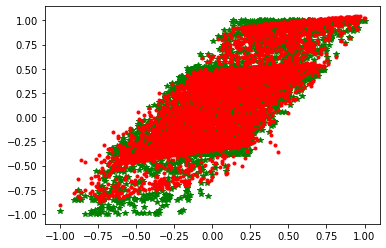

 Epoch 41 Loss:  0.0002225227071903646


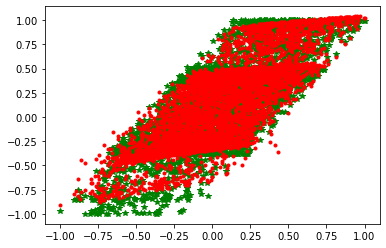

 Epoch 42 Loss:  0.00021096512500662357


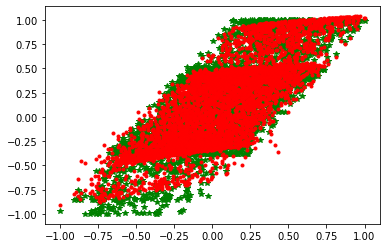

 Epoch 43 Loss:  0.00019947491819038987


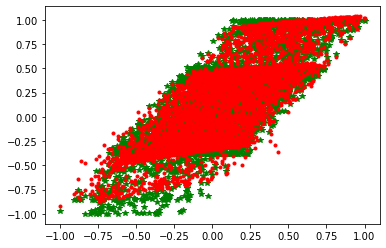

 Epoch 44 Loss:  0.00018810038454830647


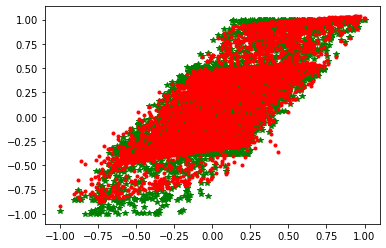

 Epoch 45 Loss:  0.00017689162632450461


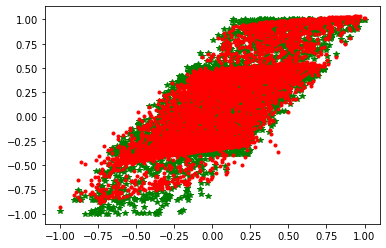

 Epoch 46 Loss:  0.00016588589642196894


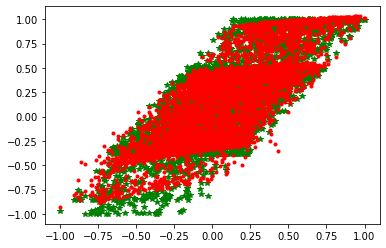

 Epoch 47 Loss:  0.00015513856487814337


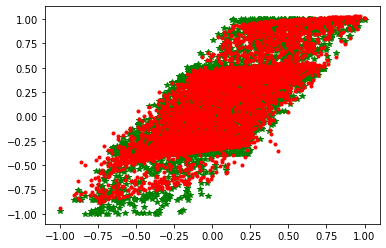

 Epoch 48 Loss:  0.0001446894893888384


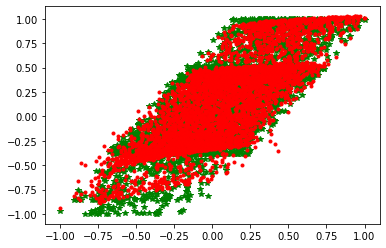

 Epoch 49 Loss:  0.00013459222100209445


In [9]:
# 训练模型
epochs = 20
plt.plot(x_train_norm.cpu(),y_train_norm.cpu(),'g*')
plt.show()
for i in range(epochs):
    pltpred = []
    
    for seq, y_train in train_data:
        optimizer.zero_grad()
        model.hidden = (torch.zeros(1,1, model.hidden_size).cuda(), torch.zeros(1,1, model.hidden_size).cuda())
        y_pred = model(seq)
        pltpred.append(y_pred)

        loss = criterion(y_pred, y_train)
        loss.backward()
        optimizer.step()
    
#     plt.plot(x,'.')
#     plt.show()
    plt.plot(x_train_norm.cpu(),y_train_norm.cpu(),'g*')
#     print(pltpred)
    plt.plot(x_train_norm.cpu(),pltpred,'r.')
    plt.show()

    print( f" Epoch {i} Loss:  {loss.item()}")

In [12]:
model.eval()
with torch.no_grad():
    model.hidden = (torch.zeros(1,1,model.hidden_size).cuda(),torch.zeros(1,1,model.hidden_size).cuda())
    print(model(torch.Tensor([-1]).cuda()).item())

0.18154695630073547
